In [183]:
import json
import requests

with open('keys.txt') as secret_file:
    keys = json.load(secret_file)
    
# Last.FM api information
lfm_api_key = keys["lfm_api_key"]
lfm_shared_secret = keys["lfm_shared_secret"]
lfm_api_base = "http://ws.audioscrobbler.com/2.0/"

headers = {
    'User-Agent': 'user Soutaisei ML project',
    'Authorization': 'Bearer {0}'.format(lfm_api_key)
}

# Acquiring a token in case future api calls require authentication
def getToken():
    api_url = lfm_api_base + '?method=auth.gettoken&api_key=' + lfm_api_key + '&format=json'
    response = requests.get(api_url, headers=headers)
    
    if response.status_code == 200:
        decoded_response = json.loads(response.content.decode('utf-8'))
        return decoded_response['token']
    
    return None

token = getToken()
token

'bFgVVgMIzCp2J1vprR_tZqM_WtuFvXJC'

In [49]:
import time

# Extracting last.fm tracks that have been played several times by the user
def getTopTracks(req_playcount):
    api_url = lfm_api_base + '?method=user.gettoptracks&user=Noppoly&api_key=' + lfm_api_key + '&format=json'
    
    current_page = 1
    extracted_tracks = []
    
    while True:
        params = {
            'period': 'overall',
            'page': current_page
        }
        
        response = requests.get(api_url, params=params, headers=headers)

        if response.status_code == 200:
            decoded_response = json.loads(response.content.decode('utf-8'))
            
            for track in decoded_response['toptracks']['track']:
                playcount = int(track['playcount'])
                if playcount < req_playcount:
                    print("Identified tracks no longer have over {} plays.".format(req_playcount))
                    print("Stopping at {} extracted tracks.".format(len(extracted_tracks)))
                    return extracted_tracks
                
                extracted_tracks.append(track)
        
        current_page += 1
        print("Advancing to page no. {} with {} extracted.".format(current_page, len(extracted_tracks)))
        time.sleep(2)
    
    
lfm_tracks = getTopTracks(req_playcount=10)

Advancing to page no. 2 with 50 extracted.
Advancing to page no. 3 with 100 extracted.
Advancing to page no. 4 with 150 extracted.
Advancing to page no. 5 with 200 extracted.
Advancing to page no. 6 with 250 extracted.
Advancing to page no. 7 with 300 extracted.
Advancing to page no. 8 with 350 extracted.
Advancing to page no. 9 with 400 extracted.
Advancing to page no. 10 with 450 extracted.
Advancing to page no. 11 with 500 extracted.
Advancing to page no. 12 with 550 extracted.
Advancing to page no. 13 with 600 extracted.
Advancing to page no. 14 with 650 extracted.
Advancing to page no. 15 with 700 extracted.
Advancing to page no. 16 with 750 extracted.
Advancing to page no. 17 with 800 extracted.
Advancing to page no. 18 with 850 extracted.
Advancing to page no. 19 with 900 extracted.
Advancing to page no. 20 with 950 extracted.
Advancing to page no. 21 with 1000 extracted.
Advancing to page no. 22 with 1050 extracted.
Advancing to page no. 23 with 1100 extracted.
Advancing to pag

In [184]:
import base64

# Spotify API information
sp_client_id = keys["sp_client_id"]
sp_client_secret = keys["sp_client_secret"]

sp_base_url = ''

# Spotify authorization
def getSpotifyAuthorizationURL():
    params = {
        'client_id': sp_client_id,
        'response_type': 'code',
        'redirect_uri': 'https://github.com/vrctin'
    }
    
    response = requests.get('https://accounts.spotify.com/authorize', params=params)
    return response.url

getSpotifyAuthorizationURL()

'https://accounts.spotify.com/login?continue=https%3A%2F%2Faccounts.spotify.com%2Fauthorize%3Fclient_id%3Dd155280dad834c76a20fbec412090a9a%26response_type%3Dcode%26redirect_uri%3Dhttps%253A%252F%252Fgithub.com%252Fvrctin'

In [51]:
# Replace with the callback from earlier
sp_code = "AQA6szHTkm4NkgZSSHNjHHVm3wHJsxlG-K0NgBDpAoWBttKsD8UUFbIY9tvHk4YO7cN7UYw1_tjLaz6UgFf6G7RghYSMFeviQKXyLaDmUa9TPHafMmoYDN26VdNwTs1C7Y9VOVPvIJSbmhhVpnvroKWttyZo2S2nMRFRVes"

def getSpotifyTokens():
    data = {
        'grant_type': 'authorization_code',
        'code': sp_code,
        'redirect_uri': 'https://github.com/vrctin',
        'client_id': sp_client_id,
        'client_secret': sp_client_secret
    }
    
    response = requests.post("https://accounts.spotify.com/api/token", data=data)
    decoded_response = json.loads(response.content.decode('utf-8'))
    return decoded_response['access_token'], decoded_response['refresh_token']

sp_access, sp_refresh = getSpotifyTokens()

In [152]:
# This comes in handy in case our access token expires
def refreshAccessToken(refresh_token):
    api_url = "https://accounts.spotify.com/api/token"
    
    params = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token,
        'client_id': sp_client_id,
        'client_secret': sp_client_secret
    }
    
    joined_client = "{}:{}".format(sp_client_id, sp_client_secret)

    
    response = requests.post(api_url, data=params)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response['access_token']

sp_access = refreshAccessToken(sp_refresh)

In [53]:
sp_api_base = "https://api.spotify.com/v1"

def searchSpotifySong(query):
    api_url = sp_api_base + "/search"
    
    params = {
        'q': query,
        'type': 'track',
        'limit': 1
    }
    
    headers = {
        'Authorization': 'Bearer ' + sp_access
    }
    response = requests.get(api_url, params=params, headers=headers)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response

In [54]:
# Make up a search term to look for using Spotify's api for each track extracted

search_terms = []
for track in lfm_tracks:
    artist_name = track['artist']['name']
    song_name = track['name']
    
    search_term = '{} - {}'.format(artist_name, song_name).lower()
    search_terms.append(search_term)

In [56]:
# Get Spotify's audio features for each search term 
track_ids = []

print("Beginning search...")

current_item = 1
failed_items = 0
for term in search_terms:
    try:
        search_result = searchSpotifySong(term)
        time.sleep(0.3)

        track_id = search_result['tracks']['items'][0]['id']
        if track_id not in track_ids:
            track_ids.append(track_id)

        current_item += 1
        if current_item % 100 == 0:
            print("Reached {} milestone. {} failed.".format(current_item, failed_items))
    except:
        failed_items += 1
    

print("Extracted {} ids.\nJob Done!".format(len(track_ids)))

Beginning search...
Reached 100 milestone. 24 failed.
Reached 200 milestone. 66 failed.
Reached 300 milestone. 112 failed.
Reached 400 milestone. 164 failed.
Reached 500 milestone. 208 failed.
Reached 600 milestone. 259 failed.
Reached 700 milestone. 333 failed.
Reached 800 milestone. 383 failed.
Reached 900 milestone. 450 failed.
Reached 1000 milestone. 513 failed.
Reached 1100 milestone. 595 failed.
Reached 1200 milestone. 644 failed.
Reached 1300 milestone. 717 failed.
Reached 1400 milestone. 771 failed.
Reached 1500 milestone. 839 failed.
Reached 1600 milestone. 921 failed.
Reached 1700 milestone. 1022 failed.
Reached 1800 milestone. 1083 failed.
Reached 1900 milestone. 1195 failed.
Reached 2000 milestone. 1306 failed.
Reached 2100 milestone. 1432 failed.
Extracted 2107 ids.
Job Done!


In [58]:
# API allows us to extract 100 audio features per call maximum
# We split the tracks we have in chunks and call the API accordingly

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

track_id_chunks = list(chunks(track_ids, 100))

def getMultipleAudioFeatures(track_ids):
    api_url= "https://api.spotify.com/v1/audio-features"
    
    params = {
        'ids': ','.join(track_ids),
    }
    
    headers = {
        'Authorization': 'Bearer ' + sp_access
    }
    response = requests.get(api_url, params=params, headers=headers)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response

audio_features = []
for chunk in track_id_chunks:
    chunk_features = getMultipleAudioFeatures(chunk)['audio_features']
    audio_features.append(chunk_features)
    
    print("Extracted features for a chunk of {} songs.".format(len(chunk_features)))
    time.sleep(2)    

Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 100 songs.
Extracted features for a chunk of 7 songs.


In [59]:
import numpy as np

# Flatten the array from two dimensions to one
audio_features_flat = np.concatenate(audio_features)
len(audio_features_flat)

2107

In [60]:
# Cleaning up the attributes not intended for clusterization
for feature in audio_features_flat:
    del feature['key']
    del feature['mode']
    del feature['type']
    del feature['id']
    del feature['uri']
    del feature['track_href']
    del feature['analysis_url']
    del feature['duration_ms']
    del feature['time_signature']
    
print(audio_features_flat[0])

{'danceability': 0.458, 'energy': 0.309, 'loudness': -14.186, 'speechiness': 0.0283, 'acousticness': 0.909, 'instrumentalness': 0.956, 'liveness': 0.118, 'valence': 0.0555, 'tempo': 106.004}


In [61]:
import pandas as pd

audio_features_dataframe = pd.DataFrame.from_records(audio_features_flat)
audio_features_dataframe.head(1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.458,0.309,-14.186,0.0283,0.909,0.956,0.118,0.0555,106.004


In [67]:
# Loudness and tempo need to be scaled from 0 to 1 like the rest of the columns
# For this, we apply a standard scaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = ['loudness', 'tempo']
audio_features_dataframe[cols_to_scale] = scaler.fit_transform(audio_features_dataframe[cols_to_scale])
audio_features_dataframe.head(1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.458,0.309,0.648937,0.0283,0.909,0.956,0.118,0.0555,0.479413


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002EEAE7903A0>,
      dtype=object)

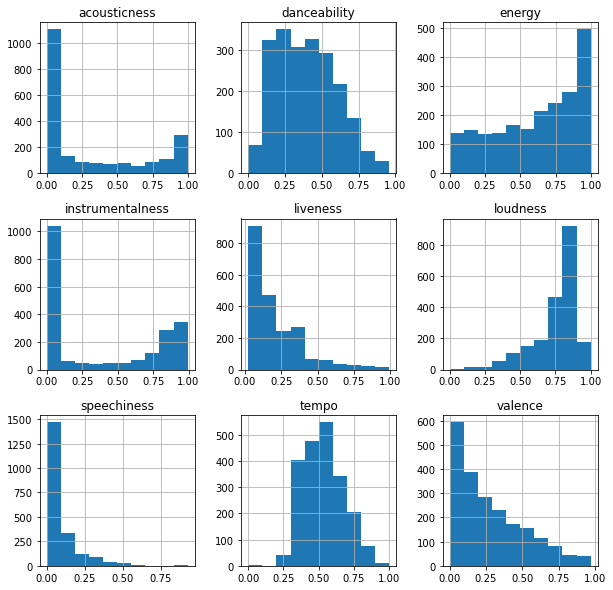

In [68]:
# Visualizing the data we have
audio_features_dataframe.hist(figsize=(10,10))

In [131]:
from sklearn.cluster import KMeans

# Training models using various amounts of clusters
# and then analyzing each one to figure the best fit

inertias = []

cols_to_drop = []
adjusted_audio_features = audio_features_dataframe.drop(columns=cols_to_drop)
for n_clusters in range(2, 10):
    print("Training with {} clusters in mind".format(n_clusters))
    kmodel = KMeans(n_clusters=n_clusters, random_state=47).fit(adjusted_audio_features)
    inertias.append(kmodel.inertia_)
    
print("Job's done.")

adjusted_audio_features

Training with 2 clusters in mind
Training with 3 clusters in mind
Training with 4 clusters in mind
Training with 5 clusters in mind
Training with 6 clusters in mind
Training with 7 clusters in mind
Training with 8 clusters in mind
Training with 9 clusters in mind
Job's done.


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.458,0.3090,0.648937,0.0283,0.90900,0.956,0.1180,0.0555,0.479413
1,0.251,0.2480,0.531587,0.0398,0.97400,0.921,0.1090,0.0670,0.297279
2,0.276,0.1550,0.463832,0.0445,0.83300,0.876,0.0809,0.0382,0.628396
3,0.201,0.0923,0.356866,0.0405,0.97900,0.907,0.0937,0.0378,0.629197
4,0.198,0.0407,0.379890,0.0385,0.91100,0.977,0.3190,0.0340,0.485844
...,...,...,...,...,...,...,...,...,...
2102,0.188,0.2200,0.703489,0.0301,0.21700,0.850,0.1050,0.0505,0.417422
2103,0.493,0.6990,0.824386,0.0407,0.18200,0.587,0.1420,0.5590,0.632743
2104,0.229,0.0923,0.192412,0.0549,0.88800,0.809,0.1260,0.1100,0.325799
2105,0.348,0.9930,0.969928,0.1110,0.00166,0.826,0.2020,0.0710,0.470969


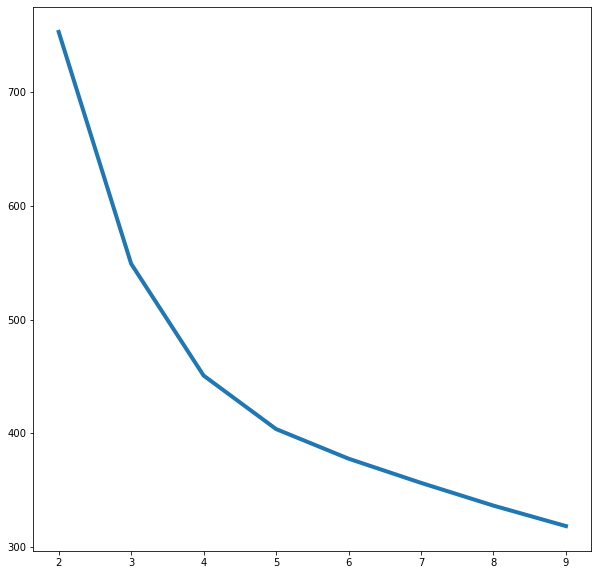

In [134]:
#%matplotlib inline

import matplotlib.pyplot as plt

#plt.rcParams["figure.figsize"] = (10, 10)

y = range(2, 10)
plt.plot(y, inertias, linewidth=4, label="Model inertia")

In [139]:
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in range(2, 10):
    print("Training with {} clusters in mind".format(n_clusters))
    kmodel = KMeans(n_clusters=n_clusters, random_state=7)
    kmodel_labels = kmodel.fit_predict(audio_features_dataframe)
    
    silhouette_avg = silhouette_score(audio_features_dataframe, kmodel_labels)
    print("Silhouette average for {} clusters: {}".format(n_clusters, silhouette_avg))
        

Training with 2 clusters in mind
Silhouette average for 2 clusters: 0.3658216843507639
Training with 3 clusters in mind
Silhouette average for 3 clusters: 0.34181475984392773
Training with 4 clusters in mind
Silhouette average for 4 clusters: 0.35195672640169623
Training with 5 clusters in mind
Silhouette average for 5 clusters: 0.2837514010132603
Training with 6 clusters in mind
Silhouette average for 6 clusters: 0.26969649550483193
Training with 7 clusters in mind
Silhouette average for 7 clusters: 0.25767771304691933
Training with 8 clusters in mind
Silhouette average for 8 clusters: 0.259895890643874
Training with 9 clusters in mind
Silhouette average for 9 clusters: 0.25300319445505765


In [144]:
# Exploring the 4 clusters option
kmodel = KMeans(n_clusters=4, random_state=7).fit(audio_features_dataframe)
predictions = kmodel.predict(audio_features_dataframe)

audio_features_4cl = audio_features_dataframe.copy()
audio_features_4cl['cluster'] = predictions

# Average feature values for each cluster
clusters = audio_features_4cl.groupby('cluster').agg('mean')
clusters

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.258724,0.209779,0.501056,0.046103,0.861511,0.883323,0.131293,0.110175,0.460098
1,0.462300,0.784534,0.841108,0.136708,0.083982,0.034038,0.251601,0.366713,0.555205
2,0.485178,0.342109,0.676426,0.082761,0.726766,0.096470,0.171528,0.321407,0.518481
3,0.325499,0.759437,0.809933,0.087094,0.066567,0.784082,0.233878,0.228188,0.544814


In [168]:
# Create a new user friendly dataframe, containing artists, songs and the cluster it's predicted to be in

def getSpotifySongs(ids):
    api_url = "https://api.spotify.com/v1/tracks"
    
    params = {
        'ids': ','.join(ids),
    }
    
    headers = {
        'Authorization': 'Bearer ' + sp_access
    }
    response = requests.get(api_url, params=params, headers=headers)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response

songs_data = []

song_id_chunks = list(chunks(track_ids, 50))
for chunk in song_id_chunks:
    songs = getSpotifySongs(chunk)
    
    for song_info in songs['tracks']:
        
        artists = []
        for artist in song_info['artists']:
            artists.append(artist['name'])

        song_artists = ', '.join(artists)
        song_name = song_info['name']

        songs_data.append({
            'artist': song_artists,
            'title': song_name
        })

        if len(songs_data) % 150 == 0:
            print("Reached {} milestone.".format(len(songs_data)))
        
    time.sleep(1)

print("Job's done")

Reached 150 milestone.
Reached 300 milestone.
Reached 450 milestone.
Reached 600 milestone.
Reached 750 milestone.
Reached 900 milestone.
Reached 1050 milestone.
Reached 1200 milestone.
Reached 1350 milestone.
Reached 1500 milestone.
Reached 1650 milestone.
Reached 1800 milestone.
Reached 1950 milestone.
Reached 2100 milestone.
Job's done


In [171]:
# The final table example
friendly_audio_features_4cl = pd.DataFrame.from_records(songs_data).join(audio_features_4cl)
friendly_audio_features_4cl.head(1)

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,Grouper,Heavy Water/I'd Rather Be Sleeping,0.458,0.309,0.648937,0.0283,0.909,0.956,0.118,0.0555,0.479413,0


In [178]:
def getNSongsOfCluster(dataframe, n, cluster):
    return dataframe[dataframe['cluster']==cluster].sample(n)
    
# Cluster 0 examples
getNSongsOfCluster(friendly_audio_features_4cl, 10, 0)

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
130,Julianna Barwick,Heading Home,0.1760,0.0425,0.614448,0.0480,0.968,0.985,0.1020,0.0745,0.363106,0
244,Chihei Hatakeyama,Light Drizzle,0.1650,0.0795,0.456925,0.0455,0.994,0.969,0.0618,0.0310,0.306428,0
1659,Nick Drake,Northern Sky,0.5300,0.2640,0.555574,0.0380,0.552,0.694,0.1330,0.4890,0.407251,0
355,Grouper,Follow in Our Dreams,0.1460,0.2600,0.538400,0.0385,0.991,0.971,0.0984,0.0370,0.645329,0
778,Neutral Milk Hotel,April 8th,0.3740,0.1750,0.609303,0.0346,0.350,0.732,0.5050,0.0348,0.500285,0
616,Lantlôs,Melting Sun V: Oneironaut,0.0564,0.1080,0.414378,0.0449,0.187,0.953,0.3000,0.0717,0.270211,0
354,Grouper,Down to the Ocean,0.1670,0.1720,0.377869,0.0403,0.995,0.649,0.1020,0.0398,0.325844,0
1012,Slint,Washer,0.4480,0.0954,0.415388,0.0304,0.378,0.517,0.0852,0.0384,0.500312,0
1588,Brian Eno,Deep Blue Day - Remastered 2005,0.1890,0.3430,0.504969,0.0453,0.817,0.916,0.0924,0.0834,0.640666,0
33,Julianna Barwick,Pyrrhic,0.0624,0.2850,0.655703,0.0414,0.951,0.938,0.1770,0.0350,0.296090,0


In [175]:
# Cluster 1 examples
getNSongsOfCluster(friendly_audio_features_4cl, 10, 1)

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
456,Behemoth,Havohej Pantocrator,0.193,0.944,0.849031,0.1300,0.000034,0.077200,0.0999,0.0604,0.520094,1
362,Slowdive,Machine Gun,0.129,0.647,0.761776,0.0383,0.195000,0.292000,0.1040,0.0393,0.698967,1
819,Kanye West,POWER,0.542,0.914,0.870692,0.1130,0.016100,0.000000,0.7440,0.5760,0.696448,1
2031,2013 Loud Speakers,My God Is The Sun - Tribute to Queens Of The S...,0.197,0.897,0.863973,0.1070,0.000923,0.000075,0.2320,0.3950,0.728296,1
1774,Dinosaur Jr.,Freak Scene,0.290,0.939,0.899542,0.0693,0.007560,0.002570,0.3270,0.2220,0.348222,1
1348,Eluveitie,Epona,0.501,0.952,0.828004,0.0851,0.002530,0.041100,0.3780,0.4740,0.655532,1
1622,Incendiary,Still Burning,0.322,0.971,0.926183,0.0683,0.000502,0.000006,0.3400,0.3710,0.704919,1
667,Ecco2k,Peroxide,0.472,0.628,0.774087,0.0525,0.365000,0.034300,0.1130,0.2810,0.746029,1
1455,Converge,Fault and Fracture,0.200,0.996,0.910161,0.1710,0.000035,0.043200,0.3330,0.0983,0.387021,1
939,Queens of the Stone Age,I'm Designer - Hot Chip Remix,0.818,0.619,0.794362,0.0390,0.086000,0.003990,0.0694,0.6970,0.547103,1


In [176]:
# Cluster 2 examples
getNSongsOfCluster(friendly_audio_features_4cl, 10, 2)

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
1949,Dylan Brady,My First Time,0.485,0.3720,0.810314,0.0467,0.490,0.442000,0.1650,0.3140,0.769022,2
473,Loggins & Messina,Brighter Days - Live Version,0.320,0.3270,0.711124,0.0394,0.485,0.024100,0.9870,0.3380,0.787596,2
855,clipping.,Dream,0.382,0.4900,0.526277,0.3530,0.757,0.000000,0.0682,0.1090,0.329430,2
775,Lingua Ignota,SORROW! SORROW! SORROW!,0.280,0.0796,0.564548,0.0368,0.940,0.000014,0.0986,0.0932,0.369460,2
520,Joey Capatelli,Swans,0.845,0.8060,0.856549,0.0617,0.760,0.443000,0.0872,0.6880,0.560838,2
258,Blind Pilot,The Story I Heard,0.739,0.4430,0.676753,0.0266,0.570,0.000895,0.0798,0.5020,0.432080,2
793,Yukari,Am I Dreaming,0.391,0.6540,0.845460,0.0397,0.699,0.474000,0.6460,0.2430,0.384660,2
780,"Nujabes, Cise Star, Akin",Feather (feat. Cise Starr & Akin from CYNE),0.565,0.7490,0.826477,0.0769,0.655,0.432000,0.1060,0.8810,0.816772,2
725,Nick Drake,Which Will,0.618,0.1880,0.587595,0.0286,0.917,0.155000,0.1040,0.4290,0.431392,2
1478,"Health, Gold Panda",Before Tigers - Gold Panda Remix,0.755,0.6370,0.724680,0.1750,0.519,0.028600,0.0982,0.2950,0.579164,2


In [177]:
# Cluster 3 examples
getNSongsOfCluster(friendly_audio_features_4cl, 10, 3)

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
1779,Duster,The Queen of Hearts,0.559,0.202,0.703935,0.0825,0.041100,0.869,0.1060,0.0395,0.444512,3
586,Jack Rose,Sunflower River Blues,0.112,0.581,0.833572,0.0377,0.258000,0.947,0.0937,0.0819,0.815967,3
708,Duster,Reed to Hillsborough,0.355,0.501,0.734923,0.0274,0.001130,0.635,0.0948,0.1250,0.427688,3
954,The Microphones,Samurai Sword,0.118,0.475,0.703113,0.0586,0.088500,0.880,0.1090,0.0547,0.675852,3
2062,Swirlies,Two Girls Kissing,0.534,0.777,0.751228,0.0314,0.002040,0.866,0.1110,0.6140,0.476134,3
1216,"clipping., Youth Code",Face (Youth Code Remix),0.481,0.861,0.808810,0.1650,0.112000,0.453,0.1970,0.3910,0.885963,3
1791,Godspeed You! Black Emperor,"Bosses Hang, Pt. III",0.223,0.750,0.772560,0.0499,0.149000,0.545,0.1020,0.0847,0.566925,3
557,Full Of Hell,Humming Miter - Live,0.152,0.945,0.805850,0.0847,0.000071,0.766,0.2410,0.0571,0.431424,3
593,Meshuggah,Bleed,0.242,0.998,0.849712,0.0895,0.000008,0.880,0.2840,0.1800,0.519334,3
55,Full Of Hell,Digital Prison,0.259,0.570,0.878539,0.0822,0.000009,0.971,0.3470,0.0315,0.438705,3


In [114]:
# Experimenting with Gaussian Mixtures

from sklearn.mixture import GaussianMixture

aics = []
bics = []
for i in range(1, 20):
    gm = GaussianMixture(n_components=i, n_init=10).fit(audio_features_dataframe)
    bics.append(gm.bic(audio_features_dataframe))
    aics.append(gm.aic(audio_features_dataframe))
    
    print("Trained with {} components in mind".format(i))

Trained with 1 components in mind
Trained with 2 components in mind
Trained with 3 components in mind
Trained with 4 components in mind
Trained with 5 components in mind
Trained with 6 components in mind
Trained with 7 components in mind
Trained with 8 components in mind
Trained with 9 components in mind
Trained with 10 components in mind
Trained with 11 components in mind
Trained with 12 components in mind
Trained with 13 components in mind
Trained with 14 components in mind
Trained with 15 components in mind
Trained with 16 components in mind
Trained with 17 components in mind
Trained with 18 components in mind
Trained with 19 components in mind


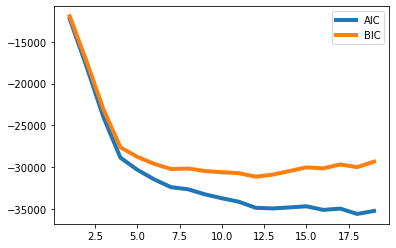

In [115]:
y = range(1, 20)
plt.plot(y, aics, linewidth=4, label="AIC")
plt.plot(y, bics, linewidth=4, label="BIC")
plt.legend()
plt.show()